In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import sys
sys.path.append('..')

from src import utils

from os import path
import joblib
import collections

ModuleNotFoundError: No module named 'src'

In [ ]:
MODEL_DATE = '20-04-08'

DATAFOLDER_PROCESSED = '/Users/navarmn/Work/Projects/2020-Corona/dev/covid19-data-processing/data/processed'
DATAFOLDER_RAW = '/Users/navarmn/Work/Projects/2020-Corona/data/raw'

STATES = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
         'DF', 'ES', 'GO', 'MA', 'MT', 'MS',
         'MG', 'PA', 'PB', 'PR', 'PE', 'PI',
         'RJ', 'RN', 'RO', 'RS', 'RR', 'SC',
         'SE', 'SP', 'TO']

MODELS = ['linear-polynomial', 'gpr', 'linear-regression']

MODELS_DETAILS = {
    'linear-polynomial': "Liner Regression + Polynomial Features degree 4",
    'gpr': "Gaussian Process Regressor - Kernel RBF",
    'linear-regression': "Liner Regression - degree 1"
}

MODELS_PATH = path.join('..', 'models')

VERSION = 0.1

In [ ]:
def load_models():
    models = collections.defaultdict(dict)
    models_metadata = collections.defaultdict(dict)
    models_details = collections.defaultdict(dict)
    models_names = collections.defaultdict(dict)

    for state in STATES:
        for model in MODELS:
#             print('Loading model {} from state {}'.format(model, state))
            # models
            model_name = 'model-{}-{}-{}-{}.pkl'.format(state, MODEL_DATE, model, VERSION)
            models[state][model] = joblib.load(path.join(MODELS_PATH, state, model_name))
            models_names[state][model] = model_name
            # metadata
            models_metadata_name = 'model-{}-{}-{}-metadata-{}.pkl'.format(state, MODEL_DATE, model, VERSION)
            models_metadata[state][model] = joblib.load(path.join(MODELS_PATH, state, models_metadata_name))
            # details
            models_details[state][model] = MODELS_DETAILS[model]


    return models, models_metadata, models_details, models_names

In [ ]:
df_states = {}
models = collections.defaultdict(dict)

for state in STATES:
    df_states[state] = pd.read_csv(path.join(DATAFOLDER_PROCESSED, '{}.csv'.format(state)), index_col=0)
    models, models_metadata, models_details, models_names= load_models()


In [ ]:
df_states['CE']

In [ ]:
models['CE']

# Replicate the error

In [ ]:
for state in STATES:
    future=10

    plt.figure(figsize=(15,10))

    df_selected = df_states[state][df_states[state]['cases'] != 0]['cases']
    # print(df_selected)
    y = df_selected.values.reshape(-1,1)
    dayone = df_selected.index[0]
    print(state)
    print(dayone)
    X = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y')).reshape(-1,1)

    X, y = utils.check_inputs(X, y)

    print('X shape: {} \n Y shape: {}'.format(X.shape, y.shape))

    for model in MODELS:    
        y_hat = models[state][model].predict(X)

    #     out = utils.forecast(models[state][model], future=future, dayone=dayone, date_string='%d/%m/%Y')
        X_fake = np.concatenate((X, np.arange(X[-1]+1, X[-1]+future+2, 1).reshape(-1,1)))
        y_hat = models[state][model].predict(X_fake)

        print('X fake shape: {} \n Y hat shape: {}'.format(X_fake.shape, y_hat.shape))

        plt.plot(X_fake, y_hat, label=model)

    plt.plot(X, y, 'black', linewidth=4, label='Real data')

    plt.legend(fontsize=22)

    plt.title(state)
    
    plt.savefig('{}.png'.format(state))

    plt.show()


# np.concatenate((X, np.arange(X[-1]+1, X[-1]+future+1, 1).reshape(-1,1)))

# Comparative of forecast and manually set

In [2]:
state =  'CE'
future = 10
print(model)

df_selected = df_states[state][df_states[state]['cases'] != 0]['cases']
y = df_selected.values.reshape(-1,1)
dayone = df_selected.index[0]
print(state)
print(dayone)
X = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y')).reshape(-1,1)
X, y = utils.check_inputs(X, y)

print('X shape: {} \n Y shape: {}'.format(X.shape, y.shape))

out = utils.forecast(models[state][model], future=future, dayone=dayone, date_string='%d/%m/%Y')
# out = utils.forecast(models[state][model], future=future)
X_fake = np.concatenate((X, np.arange(X[-1]+1, X[-1]+future+2, 1).reshape(-1,1)))
y_hat = models[state][model].predict(X_fake)

print('OUT: {}'.format(out))

print('Y_hat {}'.format(y_hat[-10:]))

NameError: name 'model' is not defined

# Negocio do pedrosa 2 exponencial

In [3]:
df_state = utils.download_state(state='CE')
df_state = df_state[df_state['cases'] != 0]
# print(df_state)
dayone = df_state[df_state['cases'] != 0].index[0]
days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
X = days.reshape(-1,1)
# y = df_state['cases'].values.reshape(-1,1)
y = utils.get_labels(df_state['cases']).reshape(-1,1)

X, y = utils.check_inputs(X, y)

NameError: name 'utils' is not defined

In [4]:
from statsmodels.tsa.api import Holt

def holt_predict(X, var_future, smoothing_level=0.5, smoothing_slope=0.05):
    model_holt = Holt(X['y'], exponential=True).fit(smoothing_level=smoothing_level, smoothing_slope=smoothing_slope, optimized=False)
    forecast = model_holt.forecast(var_future)

    # Check if predictions are belows yesterday
#     last_value = porra_df.iloc[-1]['y']
#     forecast = utils.rescale_yhat(forecast.values, last_value)
    return forecast

## Train with the last 7 days

In [11]:
DAYS_TO_TRAIN = 7
forecast_last_7 = holt_predict(utils.porra(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14)
forecast_last_7.values

/Users/navarmn/Work/Projects/venvs/data-science/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/navarmn/Work/Projects/venvs/data-science/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:222: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  ' forecasting.', ValueWarning)
/Users/navarmn/Work/Projects/venvs/data-science/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


array([2184.91924424, 2259.20578752, 2336.0180491 , 2415.44190258,
       2497.56614123, 2582.48257727, 2670.2861445 , 2761.07500444,
       2854.95065607, 2952.01804932, 3052.38570234, 3156.16582291,
       3263.4744338 , 3374.43150254])

## Train with the first 7 days and predict until now

In [12]:
DAYS_TO_TRAIN = 7
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN
forecast_first_7 = holt_predict(utils.porra(df_state.iloc[:DAYS_TO_TRAIN]), var_future=days_to_predict)
forecast_first_7.values

/Users/navarmn/Work/Projects/venvs/data-science/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


array([  233.71984335,   293.77149952,   369.25274592,   464.1280403 ,
         583.38046277,   733.2734392 ,   921.67971152,  1158.4948332 ,
        1456.15690763,  1830.29986743,  2300.57460647,  2891.68109232,
        3634.66566838,  4568.55168296,  5742.38908999,  7217.83067134,
        9072.37019013, 11403.41255074, 14333.38974019, 18016.1912524 ,
       22645.24673693, 28463.68539233, 35777.10570017, 44969.62619697,
       56524.06030948, 71047.2748845 , 89302.0643046 ])

In [13]:
DAYS_TO_TRAIN_2 = 14
days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
forecast_first_14 = holt_predict(utils.porra(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict)
forecast_first_14.values

/Users/navarmn/Work/Projects/venvs/data-science/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/navarmn/Work/Projects/venvs/data-science/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


array([  800.79415026,   991.1633852 ,  1226.78825243,  1518.42717233,
        1879.39611674,  2326.17660429,  2879.16823185,  3563.62010175,
        4410.78367326,  5459.33967617,  6757.1642383 ,  8363.51486658,
       10351.73609174, 12812.60831392, 15858.49275436, 19628.46176815,
       24294.64876338, 30070.10765834, 37218.54073261, 46066.33903689])

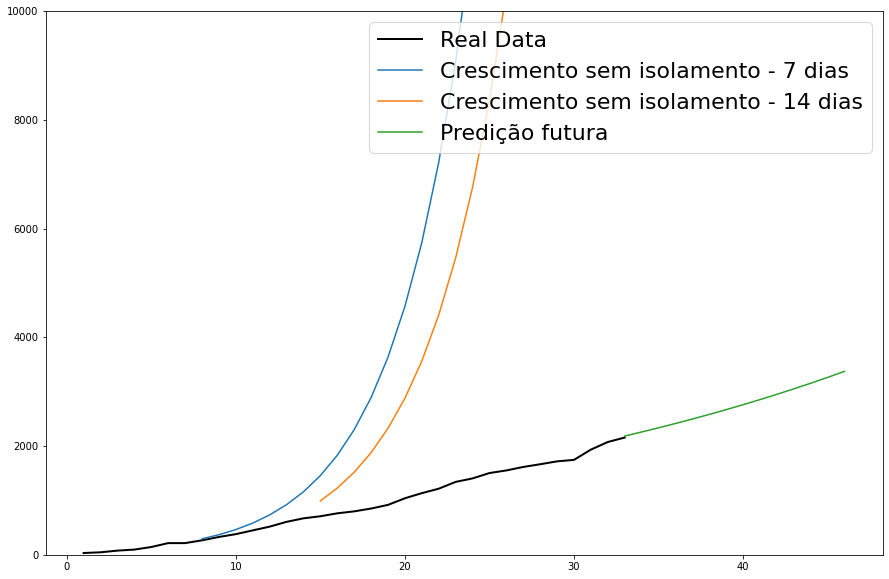

In [14]:
%matplotlib inline

plt.figure(figsize=(15,10))

plt.plot(X, y, 'black', linewidth=2, label='Real Data')
plt.plot(X[DAYS_TO_TRAIN:], forecast_first_7.values[1:], label='Crescimento sem isolamento - 7 dias')
plt.plot(X[DAYS_TO_TRAIN_2:], forecast_first_14.values[1:], label='Crescimento sem isolamento - 14 dias')
plt.plot(np.arange(X[-1], X[-1]+14, 1), forecast_last_7.values, label='Predição futura')

plt.legend(fontsize=22)
plt.ylim(0, 10000)

plt.savefig('Pedrosa.png'.format(state))

plt.show()


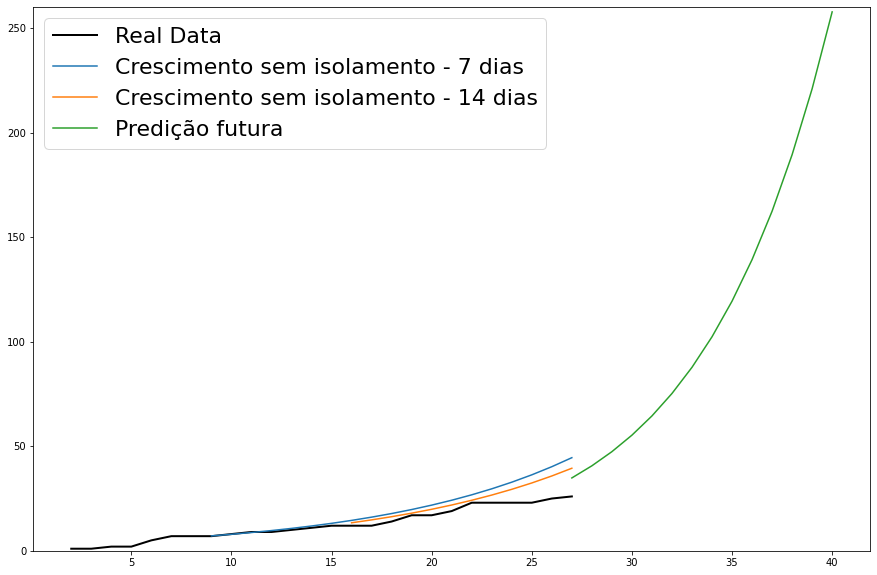

In [15]:
import warnings
warnings.filterwarnings("ignore")

STATES = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
         'DF', 'ES', 'GO', 'MA', 'MT', 'MS',
         'MG', 'PA', 'PB', 'PR', 'PE', 'PI',
         'RJ', 'RN', 'RO', 'RS', 'RR', 'SC',
         'SE', 'SP', 'TO']

STATES = ['TO']

smoothing = 0.5
slope = 0.05

slope1 = 0.05
slope2 = 0.05


for state in STATES:
    df_state = utils.download_state(state=state)
    df_state = df_state[df_state['cases'] != 0]
    # print(df_state)
    dayone = df_state[df_state['cases'] != 0].index[0]
    days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
    X = days.reshape(-1,1)
    # y = df_state['cases'].values.reshape(-1,1)
    y = utils.get_labels(df_state['cases']).reshape(-1,1)

    X, y = utils.check_inputs(X, y)

    DAYS_TO_TRAIN = 7
    forecast_last_7 = holt_predict(utils.porra(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=smoothing, smoothing_slope=slope)
    y_last_7 = forecast_last_7.values
    X_last_7 = np.arange(X[-1], X[-1]+14, 1)
    X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
    ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')


    
    DAYS_TO_TRAIN_1 = 7
    days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
    forecast_first_7 = holt_predict(utils.porra(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=smoothing, smoothing_slope=slope1)
    y_first_7 = forecast_first_7.values
    X_first_7 = X[DAYS_TO_TRAIN_1:]
    X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
    ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')
    
    
    DAYS_TO_TRAIN_2 = 14
    days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
    forecast_first_14 = holt_predict(utils.porra(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=smoothing, smoothing_slope=slope2)
    y_first_14 = forecast_first_14.values
    X_first_14 = X[DAYS_TO_TRAIN_2:]
    X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
    ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')
    
    
    plt.figure(figsize=(15,10))

    plt.plot(X, y, 'black', linewidth=2, label='Real Data')
    plt.plot(X_first_7, y_first_7, label='Crescimento sem isolamento - 7 dias')
    plt.plot(X_first_14, y_first_14, label='Crescimento sem isolamento - 14 dias')
    plt.plot(X_last_7, y_last_7, label='Predição futura')

    plt.legend(fontsize=22)
    plt.ylim(0, y[-1]*10)

    plt.savefig('{}-comparativo.png'.format(state))

    plt.show()

    exp_first_7 = {
        'yhat':y_first_7,
        'ds': ds_first_7,
        'state': state,
        'days': DAYS_TO_TRAIN_1,
        'smoothing': smoothing,
        'slope': slope1
    }
    
    exp_first_14 = {
        'yhat':y_first_14,
        'ds': ds_first_14,
        'state': state,
        'days': DAYS_TO_TRAIN_2,
        'smoothing': smoothing,
        'slope': slope2
    }
    
#     joblib.dump(exp_first_7, path.join(MODELS_PATH, state, 'exp-first-7'.format(state)))
#     joblib.dump(exp_first_14, path.join(MODELS_PATH, state, 'exp-first-14'.format(state)))


In [16]:
df_state.iloc[:20]

,cases,cured,deaths,internadosDomiciliar,internadosEnfermaria,internadosUTI,percentual_cured,percentual_deaths,percentual_internados,percentual_internadosDomiciliar,percentual_internadosEnfermaria,percentual_internadosUTI,refuses,suspects,total_internados_DB
data,,,,,,,,,,,,,,,
19/03/2020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20/03/2020,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
21/03/2020,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
22/03/2020,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23/03/2020,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24/03/2020,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25/03/2020,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26/03/2020,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27/03/2020,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
exp_first_14

{'yhat': array([13.40099815, 14.78434085, 16.31048164, 17.99416112, 19.85164151,
        21.90086373, 24.16162069, 26.65574845, 29.40733713, 32.44296362,
        35.79194823, 39.48663795]),
 'ds': ['Thu, 02 Apr 2020 00:04:00',
  'Fri, 03 Apr 2020 00:04:00',
  'Sat, 04 Apr 2020 00:04:00',
  'Sun, 05 Apr 2020 00:04:00',
  'Mon, 06 Apr 2020 00:04:00',
  'Tue, 07 Apr 2020 00:04:00',
  'Wed, 08 Apr 2020 00:04:00',
  'Thu, 09 Apr 2020 00:04:00',
  'Fri, 10 Apr 2020 00:04:00',
  'Sat, 11 Apr 2020 00:04:00',
  'Sun, 12 Apr 2020 00:04:00',
  'Mon, 13 Apr 2020 00:04:00'],
 'state': 'TO',
 'days': 14,
 'smoothing': 0.5,
 'slope': 0.05}

In [18]:
exp_first_7['state']

'TO'

In [19]:
exp_first_7['yhat'].shape

(19,)

In [20]:
len(exp_first_7['ds'])

19

In [21]:
exp_first_14['yhat'].shape

(12,)

In [22]:
len(exp_first_14['ds'])

12

In [23]:
exp_first_7['yhat'][0]

7.1315509657311305

In [24]:
utils.porra(df_state.iloc[:7])

,y
data,
19/03/2020,1
20/03/2020,1
21/03/2020,2
22/03/2020,2
23/03/2020,5
24/03/2020,7
25/03/2020,7


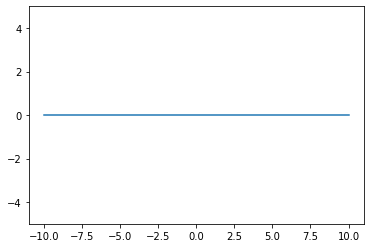

In [15]:
%matplotlib inline
from ipywidgets import interactive
import matplotlib.pyplot as plt
import numpy as np

def f(m, b):
    plt.figure(2)
    x = np.linspace(-10, 10, num=1000)
    plt.plot(x, m * x + b)
    plt.ylim(-5, 5)
    plt.show()

interactive_plot = interactive(f, m=(-2.0, 2.0), b=(-3, 3, 0.5))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [16]:
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interactive


def f(state='TO', days_to_train1=7, days_to_train2=14, smoothing1=0.5, smoothing2=0.5, slope1=0.05, slope2=0.05):
    
    
    df_state = utils.download_state(state=state)
    df_state = df_state[df_state['cases'] != 0]
    dayone = df_state[df_state['cases'] != 0].index[0]
    days = np.array(utils.count_days(dayone=dayone, date_string='%d/%m/%Y'))
    X = days.reshape(-1,1)
    y = utils.get_labels(df_state['cases']).reshape(-1,1)
    X, y = utils.check_inputs(X, y)

    DAYS_TO_TRAIN = 7
    forecast_last_7 = holt_predict(utils.porra(df_state.iloc[-DAYS_TO_TRAIN:]), var_future=14, smoothing_level=0.5, smoothing_slope=0.05)
    y_last_7 = forecast_last_7.values
    X_last_7 = np.arange(X[-1], X[-1]+14, 1)
    X_last_7, y_last_7 = utils.check_inputs(X_last_7, y_last_7)
    ds_last_7 = utils.format_date(df_state.iloc[-DAYS_TO_TRAIN:].index.tolist(), date_string_input='%d/%m/%Y')


    
    DAYS_TO_TRAIN_1 = days_to_train1
    days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_1
    forecast_first_7 = holt_predict(utils.porra(df_state.iloc[:DAYS_TO_TRAIN_1]), var_future=days_to_predict, smoothing_level=smoothing1, smoothing_slope=slope1)
    y_first_7 = forecast_first_7.values
    X_first_7 = X[DAYS_TO_TRAIN_1:]
    X_first_7, y_first_7 = utils.check_inputs(X_first_7, y_first_7)
    ds_first_7 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_1:].index.tolist(), date_string_input='%d/%m/%Y')
    
    
    DAYS_TO_TRAIN_2 = days_to_train2
    days_to_predict = df_state.shape[0] - DAYS_TO_TRAIN_2
    forecast_first_14 = holt_predict(utils.porra(df_state.iloc[:DAYS_TO_TRAIN_2]), var_future=days_to_predict, smoothing_level=smoothing2, smoothing_slope=slope2)
    y_first_14 = forecast_first_14.values
    X_first_14 = X[DAYS_TO_TRAIN_2:]
    X_first_14, y_first_14 = utils.check_inputs(X_first_14, y_first_14)
    ds_first_14 = utils.format_date(df_state.iloc[DAYS_TO_TRAIN_2:].index.tolist(), date_string_input='%d/%m/%Y')
    
    
    plt.figure(figsize=(7,5))

    plt.plot(X, y, 'black', linewidth=2, label='Real Data')
    plt.plot(X_first_7, y_first_7, label='Crescimento exponencial usando os primeiros {} dias'.format(DAYS_TO_TRAIN_1))
    plt.plot(X_first_14, y_first_14, label='Crescimento exponencial usando os primeiros {} dias'.format(DAYS_TO_TRAIN_2))
    plt.plot(X_last_7, y_last_7, label='Predição futura')

    plt.legend(fontsize=10)
    plt.ylim(0, y[-1]*5)

    plt.savefig('{}-comparativo.png'.format(state))

    plt.show()

    exp_first_7 = {
        'yhat':y_first_7,
        'ds': ds_first_7,
        'state': state,
        'days': DAYS_TO_TRAIN_1,
        'smoothing': smoothing1,
        'slope': slope1
    }
    
    exp_first_14 = {
        'yhat':y_first_14,
        'ds': ds_first_14,
        'state': state,
        'days': DAYS_TO_TRAIN_2,
        'smoothing': smoothing2,
        'slope': slope2
    }
    
#     joblib.dump(exp_first_7, path.join(MODELS_PATH, state, 'exp-first-7'.format(state)))
#     joblib.dump(exp_first_14, path.join(MODELS_PATH, state, 'exp-first-14'.format(state)))
    
#     model_exp_7 = joblib.load(path.join(MODELS_PATH, state, 'exp-first-7'.format(state)))
    
#     print('Model with {}'.format(DAYS_TO_TRAIN_1))
#     print('State: {}'.format(model_exp_7['state']))
#     print('Days: {}'.format(model_exp_7['days']))
#     print('smoothing: {}'.format(model_exp_7['smoothing']))
#     print('slope: {}'.format(model_exp_7['slope']))
    
#     model_exp_14 = joblib.load(path.join(MODELS_PATH, state, 'exp-first-14'.format(state)))
    
#     print('Model with {}'.format(DAYS_TO_TRAIN_2))
#     print('State: {}'.format(model_exp_14['state']))
#     print('Days: {}'.format(model_exp_14['days']))
#     print('smoothing: {}'.format(model_exp_14['smoothing']))
#     print('slope: {}'.format(model_exp_14['slope']))

    

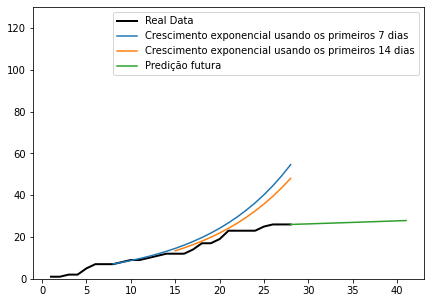

In [17]:
STATES = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE',
         'DF', 'ES', 'GO', 'MA', 'MT', 'MS',
         'MG', 'PA', 'PB', 'PR', 'PE', 'PI',
         'RJ', 'RN', 'RO', 'RS', 'RR', 'SC',
         'SE', 'SP', 'TO']

interactive_plot = interactive(f, state=STATES, days_to_train1=(3, 14), days_to_train2=(10, 21), 
                                smoothing1=(0.2, 5), smoothing2=(0.2, 5, 0.01), slope1=(0.01, 3, 0.01), slope2=(0.01, 3, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

In [ ]:
joblib